<h1>CS4619: Artificial Intelligence II</h1>
<h1>Recommender Systems II</h1>
<h2>
    Derek Bridge<br />
    School of Computer Science and Information Technology<br />
    University College Cork
</h2>
$\newcommand{\Set}[1]{\{#1\}}$ 
$\newcommand{\Tuple}[1]{\langle#1\rangle}$ 
$\newcommand{\v}[1]{\pmb{#1}}$ 
$\newcommand{\cv}[1]{\begin{bmatrix}#1\end{bmatrix}}$ 
$\newcommand{\rv}[1]{[#1]}$ 
$\DeclareMathOperator{\argmax}{arg\,max}$ 
$\DeclareMathOperator{\argmin}{arg\,min}$ 
$\DeclareMathOperator{\dist}{dist}$
$\DeclareMathOperator{\abs}{abs}$

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [3]:
from math import isnan
from seaborn import histplot
from scipy.stats import pearsonr

In [4]:
import warnings
warnings.filterwarnings("error")

<h1>Warning</h1>
<ul>
    <li>The code in this lecture is for educational purposes only &mdash; written for clarity (I hope). There is no attempt to achieve efficiency or robustness.</li>
    <li>If you want libraries for running recommender system experiments, try:
        <ul>
            <li><a href="https://elliot.readthedocs.io/en/latest/index.html#">Elliot</a></li>
            <li><a href="https://recbole.io/">RecBole</a></li>
        </ul>
    </li>
</ul>

<h1>User-Item Interactions</h1>
<ul>
    <li>Recall the ratings matrix, $\v{R}$:
        <table style="border: 1px solid; border-collapse: collapse;">
            <tr>
                <th style="border: 1px solid black; text-align: left;"></th>
                <th style="border: 1px solid black; text-align: left;">$i_1$</th>
                <th style="border: 1px solid black; text-align: left;">$i_2$</th>
                <th style="border: 1px solid black; text-align: left;">$i_3$</th>
                <th style="border: 1px solid black; text-align: left;">$i_4$</th>
                <th style="border: 1px solid black; text-align: left;">$i_5$</th>
                <th style="border: 1px solid black; text-align: left;">$i_6$</th>
            </tr>
            <tr>
                <th style="border: 1px solid black; text-align: left;">$u_1$</th>
                <td style="border: 1px solid black; text-align: left;"></td>
                <td style="border: 1px solid black; text-align: left;">2</td>
                <td style="border: 1px solid black; text-align: left;">5</td>
                <td style="border: 1px solid black; text-align: left;">3</td>
                <td style="border: 1px solid black; text-align: left;">1</td>
                <td style="border: 1px solid black; text-align: left;">2</td>
            </tr>
            <tr>
                <th style="border: 1px solid black; text-align: left;">$u_2$</th>
                <td style="border: 1px solid black; text-align: left;">5</td>
                <td style="border: 1px solid black; text-align: left;">5</td>
                <td style="border: 1px solid black; text-align: left;"></td>
                <td style="border: 1px solid black; text-align: left;">3</td>
                <td style="border: 1px solid black; text-align: left;">4</td>
                <td style="border: 1px solid black; text-align: left;"></td>
            </tr>
            <tr>
                <th style="border: 1px solid black; text-align: left;">$u_3$</th>
                <td style="border: 1px solid black; text-align: left;"></td>
                <td style="border: 1px solid black; text-align: left;"></td>
                <td style="border: 1px solid black; text-align: left;"></td>
                <td style="border: 1px solid black; text-align: left;"></td>
                <td style="border: 1px solid black; text-align: left;">3</td>
                <td style="border: 1px solid black; text-align: left;"></td>
            </tr>
            <tr>
                <th style="border: 1px solid black; text-align: left;">$u_4$</th>
                <td style="border: 1px solid black; text-align: left;">5</td>
                <td style="border: 1px solid black; text-align: left;">4</td>
                <td style="border: 1px solid black; text-align: left;">2</td>
                <td style="border: 1px solid black; text-align: left;">4</td>
                <td style="border: 1px solid black; text-align: left;">3</td>
                <td style="border: 1px solid black; text-align: left;">3</td>
            </tr>
            <tr>
                <th style="border: 1px solid black; text-align: left;">$u_5$</th>
                <td style="border: 1px solid black; text-align: left;">2</td>
                <td style="border: 1px solid black; text-align: left;">5</td>
                <td style="border: 1px solid black; text-align: left;">4</td>
                <td style="border: 1px solid black; text-align: left;">4</td>
                <td style="border: 1px solid black; text-align: left;"></td>
                <td style="border: 1px solid black; text-align: left;"></td>
            </tr>
        </table>
    </li>
   <li>We made no use of this in the simple content-based recommender system that we presented in the previous
       lecture.
    </li>
    <li>In this lecture and the next, we will see how we can make use of this data.</li>
</ul>

<h2>The MovieLens dataset</h2>
<ul>
    <li>The GroupLens rsearch group at the University of Minnesota runs a recommender system:<br />
        <a href="https://movielens.org/">https://movielens.org/</a><br />
        You can create an account, rate a few movies and start receiving recommendations. Try it!
    </li>
    <li>For several years, they have been releasing datasets, especially ratings matrices.</li>
    <li>We will use the oldest (1998!) and smallest of these in this lecture, the MovieLens 100k Dataset. The GroupLens team cleaned this dataset to eliminate users who had rated fewer than 20 movies.</li>
</ul>

In [5]:
movies = pd.read_csv("../datasets/ml_movies.txt", delimiter="|", encoding="ISO-8859-1",
            names = ["item_id", "title", "release date", "video release date",
                "IMDb URL", "unknown", "Action", "Adventure", "Animation",
                "Children\'s", "Comedy", "Crime", "Documentary", "Drama",
                "Fantasy", "Film-Noir", "Horror", "Musical", "Mystery", "Romance",
                "Sci-Fi", "Thriller", "War", "Western"]).drop([
                "release date", "video release date",
                "IMDb URL", "unknown", "Action", "Adventure", "Animation",
                "Children\'s", "Comedy", "Crime", "Documentary", "Drama",
                "Fantasy", "Film-Noir", "Horror", "Musical", "Mystery", "Romance",
                "Sci-Fi", "Thriller", "War", "Western"], axis=1)
movies["item_id"] -= 1

In [6]:
movies.head()

,item_id,title
0,0,Toy Story (1995)
1,1,GoldenEye (1995)
2,2,Four Rooms (1995)
3,3,Get Shorty (1995)
4,4,Copycat (1995)


In [7]:
ratings = pd.read_csv("ml_ratings.txt", delimiter="\t", encoding="ISO-8859-1",
                names=["user_id", "item_id", "rating", "timestamp"]).drop("timestamp", axis=1)
ratings["user_id"] -= 1
ratings["item_id"] -= 1

In [8]:
ratings.head()

,user_id,item_id,rating
0,195,241,3
1,185,301,3
2,21,376,1
3,243,50,2
4,165,345,1


In [12]:
ratings_matrix = ratings.pivot(index="user_id", columns="item_id", values="rating").fillna(0)

In [13]:
ratings_matrix

item_id,0,1,2,3,4,5,6,7,8,9,...,1672,1673,1674,1675,1676,1677,1678,1679,1680,1681
user_id,,,,,,,,,,,,,,,,,,,,,
0,5.0,3.0,4.0,3.0,3.0,5.0,4.0,1.0,5.0,3.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,4.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
938,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
939,0.0,0.0,0.0,2.0,0.0,0.0,4.0,5.0,3.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
940,5.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [9]:
user_ids = ratings["user_id"].unique()
item_ids = ratings["item_id"].unique()
num_users = len(user_ids)
num_items = len(item_ids)
num_ratings = len(ratings)
mean = ratings["rating"].mean()
num_users, num_items, num_ratings, mean

(943, 1682, 100000, 3.52986)

In [10]:
sparsity = 1 - num_ratings / (num_users * num_items)
sparsity

0.9369533063577546

<AxesSubplot:xlabel='rating', ylabel='Count'>

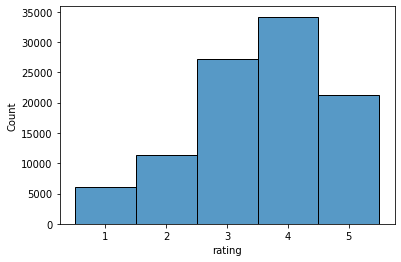

In [11]:
histplot(ratings["rating"], discrete=True)

<h2>Rating scales</h2>
<ul>
    <li>Before we use $\v{R}$, let's note a couple of problems.
        <ul>
            <li>When users give ratings, some users use the whole scale (1-5); others do not (e.g. reluctant to give a 5; or reluctant to give a 1).</li>
            <li>Some users are more positive (mostly they give 4's and 5's); others are more negative (their ratings are skewed away from the top).</li>
        </ul>
        This raises issues about whether different rows of $\v{R}$ are comparable.
    </li>
    <li>Solutions:
        <ul>
            <li>Some recommender systems already takes steps to compensate for these differences in users' ratings scales (e.g. Pearson correlation in the user-based nearest-neighbours recommender below).</li>
            <li>Otherwise, we can standardize each user's ratings.</li>
        </ul>
    </li>
    <li>There are other problems with ratings too. Can you think of any?
        <!-- Opinions change over time because tastes change over time. Opinions may need recalibration when
             new items come along. Ratings are given some time after consumption: the delay reduces reliability.
             Re-rating tasks show that users have some inconsistency.
             Item ratings tend towards the mean.
        -->
    </li>
</ul>        

<h1>Non-Personalised Recommender Systems</h1>
<ul>
    <li>Using $\v{R}$, we can define some non-personalised recommender systems.</li>
    <li>The obvious one is: $$\hat{r}_{ui} = \frac{\sum_{r \in \v{R}_i} r}{|\v{R}_i|}$$
        where $\v{R}_i = \{r_{vi} : r_{vi} \neq \bot, \forall v \in U\}$ What does this recommender do?</li>
    <li>This turns out to be a great baseline to compare against &mdash; quite hard to beat.</li>
</ul>
<!--
<h1>Supervised Content-Based Recommender System</h1>
<ul>
    <li>If we are going to do supervised learning, then we need a labeled dataset: we need target values.</li>
    <li>Let's use the ratings as the targets in a regression task.</li>
    <li>What about the features?</li>
    <li>Items:
        <ul>
            <li>We can describe each item $i$ the same way as in the simple content-based recommender: a vector
                $\v{Q}^{(i)}$ whose dimension is $d$, where the features are genres, for example.
            </li>
        </ul>
    </li>
    <li>Users:
        <ul>
            <li>In the simple content-based recommender, we described each user $u$ using a vector $\v{P}^{(u)}$
                in the same space, hence having the same dimension $d$ and the same features, e.g. genres.
            </li>
            <li>But this is no longer necessary because we're not doing item-user similarities anymore.</li>
            <li>So $\v{P}^{(u)}$ can be of dimension $d'$, where $d'$ is not necessarily the same as $d$.</li>
            <li>And the features can be genres, but they can be other things instead, or as well. For example,
                we can have demographic features such as age and sex.
            </li>
        </ul>
    </li>
    <li>Interaction features:
        <ul>
            <li>And we can have interaction features (remember these from feature engineering?).</li>
            <li>This gives us $d \times d'$ additional features.</li>
        </ul>
    </li>
    <li>(Note that the ratings are not used as features. Contrast this with collaborative recommender 
        systems below.)
    </li>
</ul>
-->
<!--
<h2>Linear regression</h2>
<ul>
    <li>Using the features from above, we can learn any model we like.</li>
    <li>Most obvious is a linear model, hence we have linear regression.</li>
    <li>If we assume that there are $d=3$ item features and $d' = 2$ user features, then the predicted rating is
        $$\hat{r}_{ui} = \v{\beta}_0 +
                        \v{\beta}_1\v{P}^{(u)}_1 +
                        \v{\beta}_2\v{P}^{(u)}_2 +
                        \v{\beta}_3\v{Q}^{(i)}_1 +
                        \v{\beta}_4\v{Q}^{(i)}_2 +
                        \v{\beta}_5\v{Q}^{(i)}_3 +
                        \v{\beta}_6\v{P}^{(u)}_1\v{Q}^{(i)}_1 +
                        \v{\beta}_7\v{P}^{(u)}_1\v{Q}^{(i)}_2 +
                        \v{\beta}_8\v{P}^{(u)}_1\v{Q}^{(i)}_3 +
                        \v{\beta}_9\v{P}^{(u)}_2\v{Q}^{(i)}_1 +
                        \v{\beta}_{10}\v{P}^{(u)}_2\v{Q}^{(i)}_2 +
                        \v{\beta}_{11}\v{P}^{(u)}_2\v{Q}^{(i)}_3$$
    </li>
    <li>Now we can use OLS regression!</li>
    <li>The number of parameters here is $1 + d' + d + d'd$ and this might cause various problems but we already know some solutions (e.g.
        dimensionality reduction, regularization, &hellip;).
    </li>
    <li>Once we have learned the linear model then, for a user $u$, we can predict a rating for each candidate and
        use these as the scores to order the candidates.
    </li>
</ul>
-->
<!--
<ul>
    <li>This is likely to be only a little bit better than the non-personalised recommender.</li>
    <li>We could probably improve it with more features or perhaps regularization, etc.
        We should also probably be rounding up/down any out-of-range predictions so that they fall within $[1,5]$,
        and possibly even rounding each individual prediction to the nearest integer.
    </li>
    <li>We should have done some model selection with a validation set but, to keep the code simple, we
        ignored this.
    </li>
</ul>
-->

In [14]:
def predict_rating_by_mean(user_id, item_id):
    # Ignores the user_id! Not personalised
    return ratings_matrix[ratings_matrix[item_id] != 0.0][item_id].mean()

In [15]:
predict_rating_by_mean(user_id=13, item_id=3)

3.550239234449761

<h1>Collaborative Filtering</h1>
<ul>
    <!--
    <li>Above, we used a user's ratings as her target values.</li>
    <li>Here, we will use ratings as both target values and features.</li>
    -->
    <li>We'll look at two recommender systems that use the ratings. 
        <ul>
            <li>User-based nearest-neighbours;</li>
            <li>Matrix factorization.</li>
        </ul>
        The first is instance-based; the second (next lecture) is model-based.
    </li>
    <li>Both are examples of <b>collaborative filtering</b>:
        <ul>
            <li>To predict $\hat{r}_{ui}$, use other people's opinions of $i$.
        </ul>
    </li>
</ul>

<h1>User-Based Nearest-Neighbours</h1>
<ul>
    <li>The idea is simple. To predict $\hat{r}_{ui}$,
        <ul>
            <li>find $k$ people who are similar to $u$ (the nearest-neighbours);</li>
            <li>take the mean of the neighbours' ratings for $i$.</li>
        </ul>
    </li>
</ul>

<h2>User-based nearest-neighbours: some details</h2>
<ul>
    <li>How do we compute similarity of two users, $u$ and $v$?
        <ul>
            <li>We take their vectors of ratings.
                <ul>
                    <li>e.g. $u_2$ is represented by $\rv{5,5,\bot,3,4,\bot}$</li>
                    <li>e.g. $u_3$ is represented by $\rv{2,5,4,4,\bot,\bot}$</li>
                </ul>
            </li>
            <li>We compute cosine similarity, for example.
                <ul>
                    <li>In fact, Pearson correlation (details not important), which lies in 
                        $[-1,+1]$, is more common. It has the advantage that it includes a form of standardization.
                    </li>
                    <li>In fact, modifications of Pearson correlation (details not important) are used to adjust 
                        for the case where $u$ and $v$ have
                        few co-rated items and to deal with some edge cases.
                    </li>
                </ul>
            </li>
        </ul>
    </li>
    <li>How many neighbours, $k$?
        <ul>
            <li>This is a hyperparameter, whose values can be chosen through a grid-search. Values of 50 or 
                100 are common.
            </li>
            <li>However, there are variants (details not important). For example, instead of finding the $k$ 
                most similar neighbours, we might find all neighbours whose similarity to $u$ exceeds some 
                threshold $\theta$. Or we might include a constraint too: e.g. we only include neighbours 
                who have a rating for candidate $i$.
            </li>
        </ul>
    </li>
    <li>How do we make the prediction?
        <ul>
            <li>Simplest is just the mean of the neighbours' ratings for $i$.</li>
            <li>But we may want a weighted mean, where weights are similarities. And, if using Pearson, we may
                want to exclude neighbours whose similarity to $u$ is negative. And we may need to handle 
                edge cases, such as where none of the neighbours has rated $i$.
            </li>
        </ul>
    </li>     
</ul>

In [16]:
def sim(user_1_id, user_2_id):
    # Get the users' ratings for co-rated items
    user_1_ratings = []
    user_2_ratings = []
    for (r1, r2) in zip(ratings_matrix.loc[user_1_id], ratings_matrix.loc[user_2_id]):
        if r1 != 0.0 and r2 != 0.0:
            user_1_ratings.append(r1)
            user_2_ratings.append(r2)
    # Return Pearson correlation, or zero if Pearson cannot be calculated
    try:
        pearson = pearsonr(user_1_ratings, user_2_ratings)[0]
        return 0.0 if isnan(pearson) else pearson
    except:
        return 0.0

In [18]:
def predict_rating_by_user_based_nn(user_id, item_id, k):
    # Get the user_ids sorted by similarity to the active user
    sorted_user_ids = np.argsort(
        [sim(user_id, u_id) for u_id in user_ids]).tolist()
    # To be a neighbour, you must have watched this movie 
    taboo_user_ids = ratings_matrix[ratings_matrix[item_id] == 0.0].index.tolist()
    # ...and you must be different from the active user
    taboo_user_ids.append(user_id)
    # Get the k neighbours
    neighbour_user_ids = [u_id for u_id in sorted_user_ids if u_id not in taboo_user_ids][:k]
    # Get the neighbours' ratings of this item
    neighbour_ratings = ratings_matrix.loc[neighbour_user_ids][item_id]
    # Return the mean of the neighours' ratings
    return neighbour_ratings.mean()

In [19]:
predict_rating_by_user_based_nn(user_id=13, item_id=3, k=50)

3.66

<h2>Discussion of user-based nearest-neighbours</h2>
<ul>
    <li>Advantages of user-based nearest-neighbours collaborative filtering include:
        <ul>
            <li>It does not require any item or user descriptions, just user-item interactions (e.g. ratings) &mdash;
                and this is data we will collect during the normal operation of the system.
            </li>
            <li>It may recommend items that are pleasantly surprising (certainly more so than content-based
                approaches), since it recommends using <em>other peoples'</em> tastes.
            </li>
            <li>New ratings can take immediate effect.</li>
        </ul>
    </li>
    <li>Its disadvantages include:
        <ul>
            <li>It is slow at prediction time. (It can be sped up by caching some of the computations
                during 'fitting'. But this may work in opposition to the point above about new ratings taking
                immediate effect.)
            </li>
            <li>It has problems recommending to cold-start users and recommending cold-start items.</li>
            <li>It can exhibit popularity bias: over-recommending popular items (although this may depend to
                some extent on details of the implementation).
            </li>
        </ul>
    </li>
    <li>Can it explain its recommendations?
        <ul>
            <li>Some people say, No. Displaying the identities of the active user’s neighbours is unlikely to be 
                effective, since the user will in general not know the neighbours; displaying their ratings is 
                unlikely to be effective, since even the ratings they have in common with the user will be too 
                large to be readily comprehended.
            </li>
            <li>Some people say, Yes. You can summarize the neighbours' opinons, e.g. using a histogram that shows
                how many of the $k$ neighbours awarded the item a 5, how many a 4, and so on. 
                (I have also published work that gives another way of explaining user-based recommendations.)
            </li>
        </ul>
    </li>
    <li>In concluding, let's mention that it is also possible to build <em>item-based</em> nearest-neighbours collaborative
        filters.
        <ul>
            <li>Without going into details, these use the similarities between item ratings (columns in the
                matrix, rather than rows).
            </li>
            <li>Famously, this is one of the methods used by Amazon.</li>
        </ul>
    </li>
</ul>

<h1>Top-N Recommendation</h1>
<ul>
    <li>Recall that recommender systems typically proceed through (at least) three steps:
        <figure>
            <img src="images/rs_arch.png" />
        </figure>
    </li>
    <li>We've now looked at three algorithms for scoring (content-based from the previous lecture, and two methods for rating prediction from this lecture).
    </li>
    <li>Let's repeat what we said previously about the third step in this diagram:
        <ul>
            <li>The obvious thing to do is to select the $N$ candidates whose scores are highest and recommend these to the user.</li>
        </ul>
    </li>
    <li>So let's implement that.</li>
</ul>

In [22]:
user_id = 11
N = 5

# Get the item_ids sorted by predicted rating
sorted_item_ids = np.argsort(
        [predict_rating_by_user_based_nn(user_id=user_id, item_id=i_id, k=50) 
         for i_id in item_ids]).tolist()
# To be a recommendation, the user must not have watched this movie 
taboo_item_ids = ratings_matrix.loc[user_id][ratings_matrix.loc[user_id] == 0.0].tolist()
# Get the item_ids for the top-N recommendations
recommended_item_ids = [i_id for i_id in sorted_item_ids if i_id not in taboo_item_ids][:N]
# Get the titles of these movies
movies.loc[recommended_item_ids]

,item_id,title
624,624,"Sword in the Stone, The (1963)"
1610,1610,Intimate Relations (1996)
1611,1611,"Leading Man, The (1996)"
1173,1173,Caught (1996)
1470,1470,Hideaway (1995)
